Step 1. Create your own custom dataset featuring 3 custom categories of at least 100 images each



In [1]:
import requests
import os

def create_folders(base_path, categories):
    """
    Creates a base directory and subdirectories for each category.

    Parameters:
    - base_path: The path of the base directory to create.
    - categories: A list of category names for which to create subdirectories.
    """
    # Create the base directory if it doesn't exist
    if not os.path.exists(base_path):
        os.makedirs(base_path)
        print(f"Created directory: {base_path}")
    else:
        print(f"Directory already exists: {base_path}")

    # Create subdirectories for each category
    for category in categories:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            os.makedirs(category_path)
            print(f"Created category directory: {category_path}")
        else:
            print(f"Category directory already exists: {category_path}")

# Your Unsplash Access Key
ACCESS_KEY = '34GkKw3D6QTt8ebbUEt5qPHG1ogzucrBo16QPy4692M'

# The categories you want to download
categories = ['Mountains', 'Beaches', 'Forests']
images_per_category = 100  # Number of images you want per category

# Directory to save the downloaded images
download_dir = './dataset'

# Create folders for the dataset
create_folders(download_dir, categories)

for category in categories:
    category_dir = os.path.join(download_dir, category)

    print(f"Downloading images for category: {category}")

    # Loop through pages to download images
    for page in range(1, (images_per_category // 30) + 2):
        # Dynamically change the query parameter for each category
        paginated_url = f"https://api.unsplash.com/search/photos?query={category}&client_id={ACCESS_KEY}&per_page=30&page={page}"
        response = requests.get(paginated_url)
        data = response.json()

        for i, photo in enumerate(data['results'], start=(page-1)*30):
            if i >= images_per_category:
                break  # Stop if we've reached the desired number of images
            image_url = photo['urls']['regular']
            image_response = requests.get(image_url)

            # Save the image
            image_path = os.path.join(category_dir, f"{category.lower()}_{i+1}.jpg")
            with open(image_path, "wb") as img_file:
                img_file.write(image_response.content)

            print(f"Downloaded {image_path}")

print("Download completed.")


Created directory: ./dataset
Created category directory: ./dataset/Mountains
Created category directory: ./dataset/Beaches
Created category directory: ./dataset/Forests
Downloaded ./dataset/Mountains/mountains_1.jpg
Downloaded ./dataset/Mountains/mountains_2.jpg
Downloaded ./dataset/Mountains/mountains_3.jpg
Downloaded ./dataset/Mountains/mountains_4.jpg
Downloaded ./dataset/Mountains/mountains_5.jpg
Downloaded ./dataset/Mountains/mountains_6.jpg
Downloaded ./dataset/Mountains/mountains_7.jpg
Downloaded ./dataset/Mountains/mountains_8.jpg
Downloaded ./dataset/Mountains/mountains_9.jpg
Downloaded ./dataset/Mountains/mountains_10.jpg
Downloaded ./dataset/Mountains/mountains_11.jpg
Downloaded ./dataset/Mountains/mountains_12.jpg
Downloaded ./dataset/Mountains/mountains_13.jpg
Downloaded ./dataset/Mountains/mountains_14.jpg
Downloaded ./dataset/Mountains/mountains_15.jpg
Downloaded ./dataset/Mountains/mountains_16.jpg
Downloaded ./dataset/Mountains/mountains_17.jpg
Downloaded ./dataset/Mou

Step 2. Split this data between 80% training and 20% test


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

def create_train_test_dirs(root_dir):
    train_dir = os.path.join(root_dir, 'train')
    test_dir = os.path.join(root_dir, 'test')

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for category in ['Mountains', 'Beaches', 'Forests']:
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

def split_dataset(root_dir, train_size=0.8):
    create_train_test_dirs(root_dir)

    for category in ['Mountains', 'Beaches', 'Forests']:
        category_path = os.path.join(root_dir, category)
        images = [os.path.join(category_path, img) for img in os.listdir(category_path)]
        train_imgs, test_imgs = train_test_split(images, train_size=train_size, random_state=42)

        for img in train_imgs:
            shutil.move(img, os.path.join(root_dir, 'train', category))
        for img in test_imgs:
            shutil.move(img, os.path.join(root_dir, 'test', category))

# Call the function to split the dataset
split_dataset('dataset')

Step 3. Preprocess the data as you see fit


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a fixed size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize images
                         std=[0.229, 0.224, 0.225])
])

# Apply transformations to the dataset
train_dataset = datasets.ImageFolder(root='./dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='./dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Step 4. Create a Convolutional Neural Network model to learn about your training set


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class MyCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        # Assuming the input images are 256x256, and there are three pooling layers
        # The size of the output feature map before the fully connected layer is 64x32x32
        # Correcting the size for the linear layer's input
        self.fc = nn.Linear(64 * 32 * 32, num_classes)  # This line seems correct given the pooling, but let's ensure the forward method matches
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        # Correctly flatten the output for the fully connected layer
        # The size of the tensor at this point should match the input of the linear layer
        x = x.view(-1, 64 * 32 * 32)  # Ensure this matches the actual output size
        x = self.fc(x)
        return x

# Initialize the model
model = MyCNN(num_classes=3)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


Step 5. Make predictions on the test data and compare them to the expected categories


In [5]:
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)

    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
#Calculate the overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the CNN model on the test set: {accuracy}%')



Epoch 1/5, Train Loss: 11.5537, Test Accuracy: 65.00%
Epoch 2/5, Train Loss: 7.2846, Test Accuracy: 58.33%
Epoch 3/5, Train Loss: 4.7665, Test Accuracy: 51.67%
Epoch 4/5, Train Loss: 2.6706, Test Accuracy: 66.67%
Epoch 5/5, Train Loss: 2.2589, Test Accuracy: 58.33%
Accuracy of the CNN model on the test set: 58.333333333333336%


Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.


In [6]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

# Load the pre-trained GoogleNet model
model = models.googlenet(pretrained=True)

# Freeze the parameters (weights) of the model to avoid updating them during training
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer (fc layer) with a new Linear Layer for custom classes
num_ftrs = model.fc.in_features
num_classes = 3  # Update this to your number of classes
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the transforms for the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the datasets
train_dataset = ImageFolder(root='./dataset/train', transform=transform)
test_dataset = ImageFolder(root='./dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Only optimize the parameters of the final layer
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 122MB/s]


Step 7: Train the GoogleNet model and compare the accuracy with the first model.


In [7]:
def train_model(model, criterion, optimizer, train_loader, epochs=5):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy}%')
    return accuracy

train_model(model, criterion, optimizer, train_loader, epochs=5)
googleNet_accuracy = evaluate_model(model, test_loader)


Epoch 1/5, Loss: 1.1111534535884857
Epoch 2/5, Loss: 1.0451504290103912
Epoch 3/5, Loss: 0.9646288156509399
Epoch 4/5, Loss: 0.9143512770533562
Epoch 5/5, Loss: 0.83295489102602
Accuracy on the test set: 78.33333333333333%


The accuracy increased after using GoogleNet.

Predciting the images.

In [9]:
# Load and preprocess the unseen image
from PIL import Image

image_path = 'test_img.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


The predicted class is: Forests


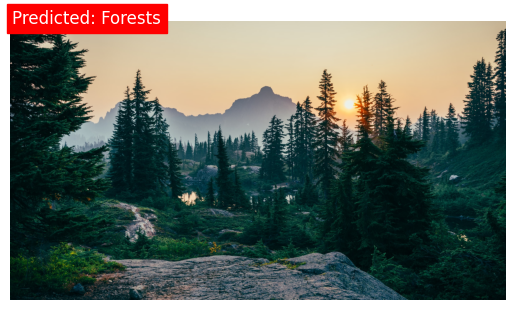

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['Beaches', 'Forests', 'Mountains']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')
# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

GitHin link:

https://github.com/shruti-si/Deep-Learning